## Modelling

In this chapter we are going to train few simple classifiers, discover issues specific to the dataset, present several ways to target them in future model developments.

In [80]:
import os
from itertools import chain
from functools import partial

import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 14

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc

from imblearn.ensemble import EasyEnsembleClassifier

In [55]:
data_path = "/afs/cern.ch/user/a/ananiev/cernbox/output/"

In [3]:
data = pd.read_csv(os.path.join(data_path, "hgg_features.tsv"), sep="\t")

In [4]:
RANDOM_STATE = 23

## Descriptive statistics

First of all let's look at the event counts, and how the weights are distributed among these events:

* **event_num** — number of events per process
* **weight_sums** — sum of weights per process
* **weight_frac** — fraction of weights per process normalized to the total weight of all events
* **weight_per_event** — average weight of event within the process

In [5]:
def weight_descriptive(data):
    res = {}
    
    event_counts = data["label"].value_counts().sort_values(ascending=False)
    res["event_num"] = event_counts
    
    weight_sums = data.groupby("label")["weight"].sum().sort_values(ascending=False)
    res["weight_sums"] = weight_sums
    
    weight_frac = weight_sums/data["weight"].sum()
    res["weight_frac"] = weight_frac
    
    weight_per_event = weight_sums/event_counts
    res["weight_per_event"] = weight_per_event
    
    return pd.DataFrame(res)
weight_descriptive(data)

,event_num,weight_sums,weight_frac,weight_per_event
VBF,10369,9.612055e-05,0.064293,9.269992e-09
Wp,2112,1.702021e-05,0.011384,8.058813e-09
Z,4571,1.697019e-05,0.011351,3.712578e-09
gg,26258,1.364896e-03,0.912952,5.198020e-08
tt,9861,2.851057e-08,0.000019,2.891245e-12


To summarize:

* **tt** events are not a lot, and they have relatively small weight
* **Wp**, **Z** are quite few, but the weight is significant
* **VBF** are quite a lot and the weight is mediocre
* **gg** are the decent majority, while their weight is quite small

Also we list features we can use during training:

In [6]:
data.columns

Index(['photon_n', 'photon_1lead_pt', 'photon_1lead_eta', 'photon_1lead_phi',
       'photon_1lead_E', 'photon_1lead_etcone20', 'photon_2lead_pt',
       'photon_2lead_eta', 'photon_2lead_phi', 'photon_2lead_E',
       'photon_2lead_etcone20', 'h_mass', 'lep_n', 'lep_pt_min', 'lep_pt_max',
       'lep_pt_mean', 'lep_pt_sum', 'lep_pt_std', 'lep_phi_min', 'lep_phi_max',
       'lep_phi_mean', 'lep_phi_sum', 'lep_phi_std', 'lep_E_min', 'lep_E_max',
       'lep_E_mean', 'lep_E_sum', 'lep_E_std', 'lep_theta_min',
       'lep_theta_max', 'lep_theta_mean', 'lep_theta_sum', 'lep_theta_std',
       'lep_charge_min', 'lep_charge_max', 'lep_charge_mean', 'lep_charge_sum',
       'lep_charge_std', 'lep_z0_min', 'lep_z0_max', 'lep_z0_mean',
       'lep_z0_sum', 'lep_z0_std', 'lep_ptcone30_min', 'lep_ptcone30_max',
       'lep_ptcone30_mean', 'lep_ptcone30_sum', 'lep_ptcone30_std',
       'lep_etcone20_min', 'lep_etcone20_max', 'lep_etcone20_mean',
       'lep_etcone20_sum', 'lep_etcone20_std', 'wei

Let's train baseline model with ensemble of trees in order to identify at least somewhat relevant features to the analysis

In [7]:
def train_test_val_split(dataset, target, test_size, val_size, *args, **kwargs):
    shuffle = kwargs.get("shuffle", True)
    del kwargs["shuffle"]
    X_train_val, X_test, y_train_val, y_test = train_test_split(data.drop(columns=[target]), data[target], *args, test_size=test_size, shuffle=shuffle, **kwargs)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, shuffle=False, **kwargs)
    return (pd.concat([X_train, y_train], axis="columns"),
            pd.concat([X_val, y_val], axis="columns"),
            pd.concat([X_test, y_test], axis="columns"))

We split dataset into training, validation and test samples. Test sample constitute 20% of the data, while validation sample is 8%. Rest 72% are training samples.

In [8]:
d_train, d_val, d_test = train_test_val_split(data, "label", 0.2, 0.1, shuffle=True, random_state=RANDOM_STATE)

In [9]:
class KeepFeatures(TransformerMixin):
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X[self.features].copy()

In [10]:
class FillNa(TransformerMixin):
    def __init__(self, mapping):
        if isinstance(mapping, dict):
            self.mapping = mapping
            self.value = None
        else:
            self.value = mapping
            self.mapping = None
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        res = X.copy()
        if self.mapping is not None:
            for col, val in self.mapping.items():
                res[col].fillna(val, inplace=True)
        if self.value is not None:
            res.fillna(self.value, inplace=True)
        return res

In [11]:
def pipeline_maker(pipeline, *args,  **kwargs):
    def instantiate():
        return pipeline(*args, **kwargs)
    return instantiate

Initially we choose features describing the event in general (e.g. photon number, lepton number, missing energy), then, since two photons are important features of the event we pick two the most energetic photons and include all the features describing them in detail (e.g. eta, phi, pt, E). Then we include aggregated features for leptons, like sum of phi, sum of energies, sum of theta. Finally, we include `h_mass`.

Sometimes there are no leptons in the event, then we impose zero values for all the features describing them.

Find the full feature list below.

In [12]:
BaselineFeaturePipeline = \
    pipeline_maker(Pipeline, steps=[
        ('keep_features', KeepFeatures(['photon_n', 'photon_1lead_pt',
                                        'photon_1lead_eta', 'photon_1lead_phi',
                                        'photon_1lead_E', 'photon_1lead_etcone20',
                                        'photon_2lead_pt', 'photon_2lead_eta',
                                        'photon_2lead_phi', 'photon_2lead_E',
                                        'photon_2lead_etcone20', 'h_mass',
                                        'met_et', 'met_phi', 'lep_pt_sum',
                                        'lep_phi_mean', 'lep_phi_std', 'lep_E_sum',
                                        'lep_theta_mean', 'lep_theta_std',
                                        'lep_charge_sum', 'lep_ptcone30_sum',
                                        'lep_etcone20_sum', 'label', 'weight'])),
        ('filna', FillNa(0.))
    ])
baseline_feature_pipeline = BaselineFeaturePipeline().fit(d_train)
baseline_features = baseline_feature_pipeline.transform(d_train)
baseline_features

,photon_n,photon_1lead_pt,photon_1lead_eta,photon_1lead_phi,photon_1lead_E,photon_1lead_etcone20,photon_2lead_pt,photon_2lead_eta,photon_2lead_phi,photon_2lead_E,...,lep_phi_mean,lep_phi_std,lep_E_sum,lep_theta_mean,lep_theta_std,lep_charge_sum,lep_ptcone30_sum,lep_etcone20_sum,label,weight
34762,2,61186.055,0.745909,1.857736,79011.390,-214.42026,58043.250,-0.610472,-2.745476,69199.020,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,tt,3.535056e-12
17522,2,57509.270,-0.547249,-3.109003,66337.810,-519.36290,49587.080,0.501637,-0.035371,55958.066,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,gg,6.375784e-08
47589,2,57872.516,-0.576206,-0.812393,67748.520,-733.14470,46447.676,0.728025,2.388419,59310.140,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,gg,6.258318e-08
1178,2,156658.190,0.683966,-2.048359,194752.220,-242.73482,37639.945,0.693092,2.438658,47048.370,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,Z,4.440460e-09
44652,2,84145.766,0.430823,-1.531170,92076.400,-1019.32764,27554.098,-1.093629,1.668323,45740.984,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,gg,6.191731e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27005,2,66853.030,1.625911,0.868543,176484.560,-913.14026,42325.800,0.195025,-1.363790,43133.280,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,VBF,1.540992e-08
3731,2,63004.390,0.887710,-0.333082,89502.695,-1976.89830,57729.113,-0.742256,-1.374505,74375.516,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,VBF,5.338199e-09
19695,2,81314.836,1.139199,-2.058962,140037.980,-794.09393,65658.380,0.297407,-0.524126,68583.625,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,VBF,1.139801e-08
40489,2,73674.766,0.438450,-2.611038,80870.510,-242.98242,53581.746,-0.156901,1.061709,54242.637,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,gg,9.122884e-08


In [13]:
def split_targets(data, targets, drop=None):
    flat_target = False
    if not isinstance(targets, list):
        flat_target = True
    to_drop = drop if drop is not None else []
    to_drop += targets if not flat_target else [targets]
    
    Xs = data.drop(columns=to_drop)
    ys = data[targets]
    
    return Xs, ys

As a baseline model we pick RandomForestClassifier. RandomForest is useful to pick relevant features when the dataset possibly includes correlated features. Correlations are weakend because RandomForest picks a subset of features to train each tree.

In [14]:
baseline_model = RandomForestClassifier(random_state=RANDOM_STATE).fit(*split_targets(baseline_features, "label", drop=["weight"]), sample_weight=baseline_features["weight"])

In [15]:
def extract_importances(feature_importances, feature_names):
    return pd.DataFrame(zip(feature_names, feature_importances),
                                      columns=["feature", "score"]) \
             .set_index("feature") \
             .sort_values("score", axis="index", ascending=False)

In [16]:
def get_ensemble_feature_importances(ensemble_model):
    importances = []
    for est in ensemble_model.estimators_:
        importances.append(est.steps[-1][1].feature_importances_)
    importances = np.vstack(importances)
    return np.median(importances, axis=0)

In [127]:
def report_importances(model, X_test):
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
    elif hasattr(model, "estimators_") and hasattr(model.estimators_[0].steps[-1][1], "feature_importances_"):
        feature_importances = get_ensemble_feature_importances(model)
    else:
        print("Model doesn't seem to provide feature importances. Skip feature importances report")
        return
    nice_importances = extract_importances(feature_importances, X_test.columns)
    fig, ax = plt.subplots()
    ax.set_title("Feature importances")
    nice_importances.plot(kind="barh", ax=ax)
    fig.tight_layout()
    return {"importances": fig}

In [133]:
def report_class_summary(model, feature_pipeline, X_test, y_test, weights=None):
    if not hasattr(model, "classes_"):
        print("Model doesn't seem to be a classificator. Skip classification summary report")
        return
    classes = model.classes_
    labeler = feature_pipeline.named_steps.get("labels")
    if labeler is not None:
        classes = labeler.transformer.inverse_transform(classes)
        
    pred = model.predict(X_test)
    conf = confusion_matrix(y_test, pred)
    conf_fig, ax = plt.subplots()
    ax.set_title("Confusion matrix")
    disp = ConfusionMatrixDisplay(conf, classes)
    disp.plot(ax=ax)
    conf_fig.tight_layout()
    
    conf = confusion_matrix(y_test, pred, sample_weight=weights)
    conf_weight_fig, ax = plt.subplots()
    ax.set_title("-Log10 confusion matrix of weights")
    disp = ConfusionMatrixDisplay(-np.log10(conf), classes)
    disp.plot(ax=ax)
    conf_weight_fig.tight_layout()
    
    return {"confusion": conf_fig,
            "confusion_weights": conf_weight_fig}

In [134]:
def report_descriptive(X_test, y_test, weights=None):
    data = pd.concat([X_test, y_test], axis="columns")
    if weights is not None:
        data = data.assign(weight=weights)
        
    if "weight" in X_test.columns:
        weight_sums = data.groupby(["label"])[["weight"]].sum()
        print("Sum of weights")
        display(weight_sums)

In [135]:
def report(model, feature_pipeline, d_test, drop=None):
    X_test, y_test = split_targets(d_test, "label", drop=drop)
    weights = d_test["weight"]
    
    figures = {}
    report_descriptive(X_test, y_test, weights=weights)
    figures.update(
        report_class_summary(model, feature_pipeline, X_test, y_test, weights=weights)
    )
    figures.update(
        report_importances(model, X_test)
    )
    return figures

In [136]:
def save_figures(name, figures):
    for label, fig in figures.items():
        fig.savefig(os.path.join("output/", f"{name}_{label}.png"))

After the model has been trained, let's see the report describing the baseline.

We have 5 classes and a confusion matrix for them.

We also provide confusion matrix for weights in somewhat sophisticated format. Due to weights can differ by orders of magnitude, it is easier to compare logarithms. Since all weights are < 1, it is convenient to remove minus sign close to numbers in the matrix. As a result, the smaller number on the diagonal of the matrix the better.

Finally we show feature importances coming from decision tree classifier.

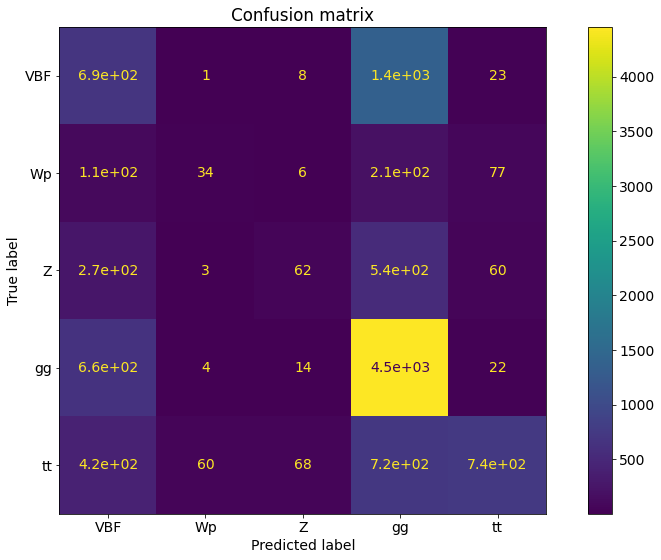

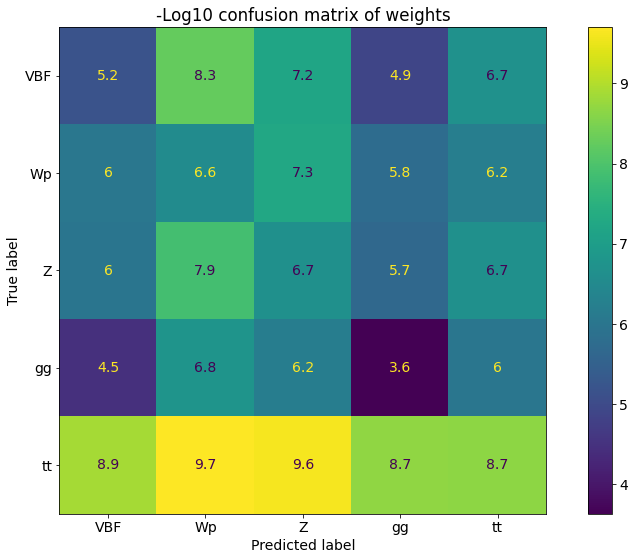

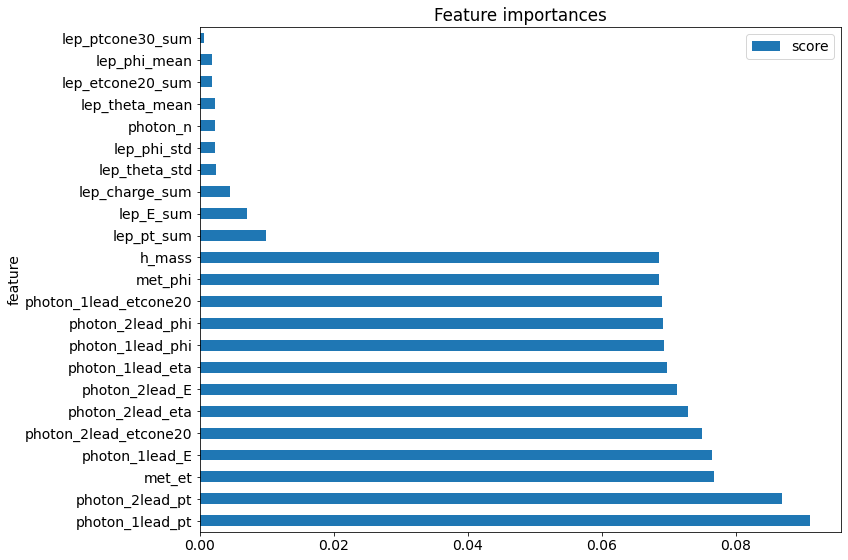

In [137]:
save_figures(
    "random-forest",
    report(baseline_model, baseline_feature_pipeline, baseline_feature_pipeline.transform(d_test), drop=["weight"])
)

Apparently `gg` events are so many, that other events become classified as `gg` just statistically. This means that the dataset is imbalanced, and we should find some approach to target this issue.

We also choose subset of features to work with. We pick only significantly relevant features. See the list of them below.

In [22]:
def mask_by_levels(data, threshold=None, limit=None):
    thr_mask = np.array(True)
    if threshold is not None:
        if isinstance(threshold, dict):
            thr_mask = np.all([data[k] > v for k,v in threshold.items()])
        else:
            thr_mask = np.all(data > threshold, axis=1)
    
    lim_mask = np.array(True)
    if limit is not None:
        if isinstance(limit, dict):
            lim_mask = np.all([data[k] < v for k,v in limit.items()])
        else:
            lim_mask = np.all(data < limit, axis=1)
            
    mask = thr_mask & lim_mask
    return mask

In [23]:
def filter_by_levels(data, threshold=None, limit=None):
    mask = mask_by_levels(data, threshold=threshold, limit=limit)
    
    if np.all(mask):
        return data.copy()
    else:
        return data[mask].copy()

In [24]:
subcolumns = list(filter_by_levels(
                extract_importances(
                    baseline_model.feature_importances_,
                    split_targets(baseline_features, "label", drop=["weight"])[0].columns
                ),
                threshold=0.05
             ).index)
subcolumns

['photon_1lead_pt',
 'photon_2lead_pt',
 'met_et',
 'photon_1lead_E',
 'photon_2lead_etcone20',
 'photon_2lead_eta',
 'photon_2lead_E',
 'photon_1lead_eta',
 'photon_1lead_phi',
 'photon_2lead_phi',
 'photon_1lead_etcone20',
 'met_phi',
 'h_mass']

In [25]:
class WithColumns(TransformerMixin):
    def __init__(self, transformer, columns=None):
        self.columns = columns
        self.transformer = transformer
        
    def fit(self, X, y=None, **fit_params):
        self.transformer.fit(X[self.columns])
        return self
    
    def transform(self, X, y=None, **fit_params):
        res = X.copy()
        res[self.columns] = self.transformer.transform(res[self.columns])
        return res

In [26]:
class ReplaceValues(TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        res = X.replace(self.mapping)
        return res
# WithColumns(ReplaceValues({
#                                 "VBF": "other",
#                                 "Wp": "other",
#                                 "Z": "other",
#                                 "gg": "other"
#                                }), columns="label").fit_transform(d_test)

In [27]:
class DropByLevel(TransformerMixin):
    def __init__(self, column, threshold=None, limit=None):
        self.column = column
        self.threshold = threshold
        self.limit = limit
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        mask = mask_by_levels(X[self.column], threshold=self.threshold, limit=self.limit)
        
        if np.all(mask):
            return X.copy()
        
        return X[mask].copy()

In [28]:
class DropByValues(TransformerMixin):
    def __init__(self, column, values):
        self.column = column
        self.values = values
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        mask = ~np.any([X[self.column] == v for v in self.values], axis=0)
        
        if np.all(mask):
            return X.copy()
        
        return X[mask].copy()
# DropByValues("label", ["tt"]).fit_transform(d_train)

Feature processing for next to baseline model, we name it `significant imbalanced model` is a bit more complex. As before, we fill empty values for chosen features with zeros.

We also drop `tt`, `Wp` and `Z` events for this step. We try to focus on events that have similar weight per event. `Wp` and `Z` are few but they are very heavy, while `tt` are quite a lot but weight is tiny. It is quite hard to handle such a mixture together.

Now we end up with `gg` and `VBF` events. The dataset is still imbalanced from the number of events perspective, but at the same time we can bother less about their weights.

As a part of feature processing, we also drop negative weights. That's just a technical issue, because the algorithm we are going to apply can't handle negative weights.

In [29]:
SignificantFeaturePipeline = \
    pipeline_maker(Pipeline, steps=[
        ('keep_features', KeepFeatures(subcolumns + ["label", "weight"])),
        ('filna', FillNa(0.)),
        ('drop_tt', DropByValues("label", ["tt", "Wp", "Z"])),
        ('drop_neg_weight', DropByLevel(["weight"], threshold=0)),
        ('labels', WithColumns(LabelEncoder(), columns="label"))
    ])
significant_feature_pipeline = SignificantFeaturePipeline().fit(d_train)
significant_features = significant_feature_pipeline.transform(d_train)
significant_features

,photon_1lead_pt,photon_2lead_pt,met_et,photon_1lead_E,photon_2lead_etcone20,photon_2lead_eta,photon_2lead_E,photon_1lead_eta,photon_1lead_phi,photon_2lead_phi,photon_1lead_etcone20,met_phi,h_mass,label,weight
17522,57509.270,49587.080,24200.309,66337.810,-94.554214,0.501637,55958.066,-0.547249,-3.109003,-0.035371,-519.36290,-0.051363,119516.130,1,6.375784e-08
47589,57872.516,46447.676,40232.438,67748.520,-1234.568200,0.728025,59310.140,-0.576206,-0.812393,2.388419,-733.14470,2.524073,119186.875,1,6.258318e-08
44652,84145.766,27554.098,51859.027,92076.400,-86.023605,-1.093629,45740.984,0.430823,-1.531170,1.668323,-1019.32764,1.554219,129246.170,1,6.191731e-08
29709,73832.836,41363.820,54375.840,81773.960,-1200.018900,-0.561445,48056.250,0.459741,-2.871648,0.420344,-786.47240,0.346971,123697.970,1,4.847792e-08
43025,63447.668,51555.555,45032.043,108673.080,-328.382870,-0.104425,51836.906,1.132488,-0.659084,1.424528,-1129.62730,2.748239,119599.125,1,3.888226e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35735,48830.830,48478.434,10524.696,61091.420,-323.829160,-0.914525,70203.940,0.694590,2.793305,-1.118841,-579.96560,-0.686762,122219.350,1,6.394328e-08
27005,66853.030,42325.800,71642.560,176484.560,-1256.716200,0.195025,43133.280,1.625911,0.868543,-1.363790,-913.14026,-1.225946,127275.800,0,1.540992e-08
3731,63004.390,57729.113,78592.805,89502.695,-372.513120,-0.742256,74375.516,0.887710,-0.333082,-1.374505,-1976.89830,2.781973,125533.550,0,5.338199e-09
19695,81314.836,65658.380,59611.215,140037.980,-868.619570,0.297407,68583.625,1.139199,-2.058962,-0.524126,-794.09393,1.200092,122452.530,0,1.139801e-08


In [30]:
np.all(significant_features["weight"] > 0)

True

Following the reference about usage of [bagging for imbalanced datasets](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/) we focus on the model of Easy Ensemble. It is an ensemble model, where AdaBoost (a variant of BDT) is used as a base estimator. The goal is to downsample major class in order to balance the trainig sample.

To avoid throwing out the data we train 6 different AdaBoosts on different samples, where minority class is always entirely included, while events from majority class are downsampled to fit number of events in the minority class.

After 6 different base estimators have been trained, the voting procedure decides on the prediction for the specific test event.


\* Note: we had to monkey-patch the AdaBoostClassifier to allow EasyEnsemble implementation to use sample weights. See details in the full version of the notebook in the github repo.

In [31]:
class WeightedAdaBoost(AdaBoostClassifier):
    def __init__(self,
                 base_estimator=None, *,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None, weights_column=None):

        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state)
        self.weights_column = weights_column
    
    def fit(self, X, y):
        super().fit(np.delete(X, self.weights_column, 1), y, sample_weight=X[:, self.weights_column])
        
    def predict(self, X):
        return super().predict(np.delete(X, self.weights_column, 1))
    
    def predict_proba(self, X):
        return super().predict_proba(np.delete(X, self.weights_column, 1))

In [32]:
sign_imbal_model = EasyEnsembleClassifier( \
                                          n_estimators=6,
                                          base_estimator=WeightedAdaBoost(weights_column=list(split_targets(significant_features, "label")[0].columns).index("weight")),
                                          random_state=RANDOM_STATE,
                                          sampling_strategy="not minority",
                                          replacement=False
                                         ) \
                   .fit(*split_targets(significant_features, "label"))

We build a report following the same structure as we had for the baseline model.

Here we have 2 classes with a simple confusion matrix. It shows that we still didn't manage to fight the imbalance.

Since here we have ensemble of BDTs, as feature importance we show median of scores per feature.

Sum of weights


,weight
label,
0,0.000019
1,0.000268


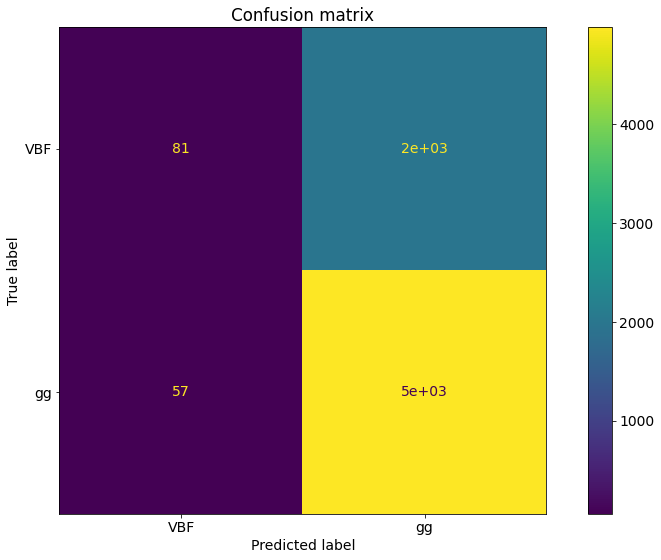

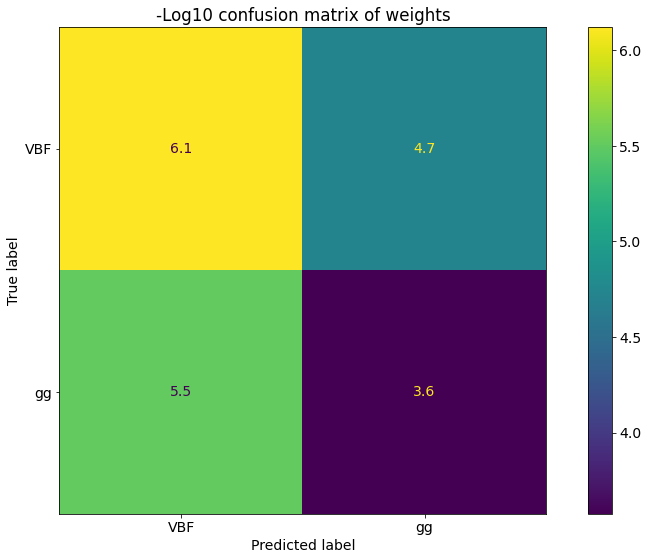

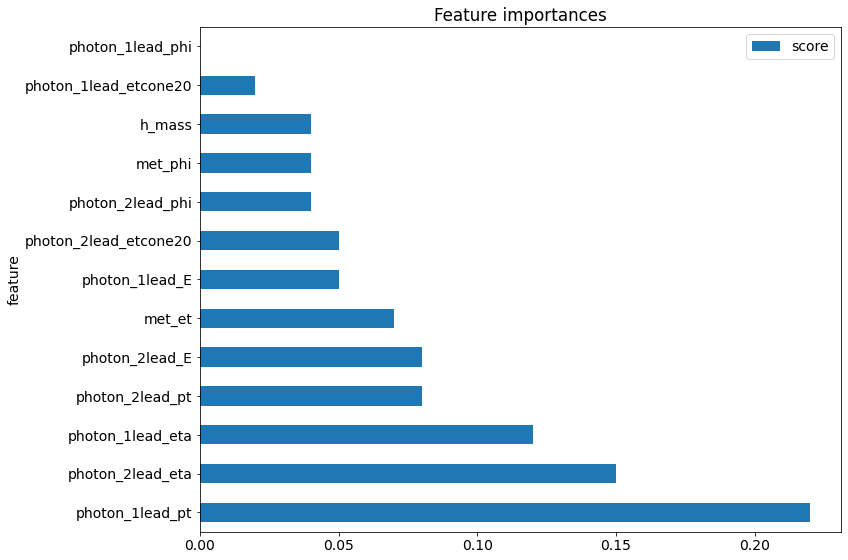

In [142]:
save_figures(
    "easy-ensemble",
    report(sign_imbal_model, significant_feature_pipeline, significant_feature_pipeline.transform(d_test))
)

AdaBoost can be treated as a specific representative of the class of the additive models. XGBoost is more generic and allows optimizing any model from the class. XGBoost uses gradient descent approach to optimize parameters of the model, while AdaBoost applies reweighting to the datasample at each step, in order to train on the most outlying data points. The latter effectively leads to exponential loss function.

More on AdaBoost vs XGBoost comparison:

* https://datascience.stackexchange.com/questions/39193/adaboost-vs-gradient-boosting
* https://stats.stackexchange.com/questions/164233/intuitive-explanations-of-differences-between-gradient-boosting-trees-gbm-ad

In [138]:
xgboost_cv = GridSearchCV(XGBClassifier(random_state=RANDOM_STATE,
                                        objective="multi:softmax",
                                        num_class=2),
                          param_grid={
                            "learning_rate": [1E-10, 1E-6],
                            "max_depth": [10, 20] ,
                            "gamma": [0.1, 0.5, 1.2],
                            "reg_alpha": [1E-3, 1E-1],
                            "reg_lambda": [1E-3, 1E-1]
                          }, cv=3)

In [139]:
xgboost_cv.fit(*split_targets(significant_features, "label", drop=["weight"]),
               sample_weight=significant_features["weight"])

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

In [140]:
xgboost_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1e-10, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=2, num_parallel_tree=1,
              objective='multi:softmax', random_state=23, reg_alpha=0.001,
              reg_lambda=0.001, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/xgboost/sklearn.py:691: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


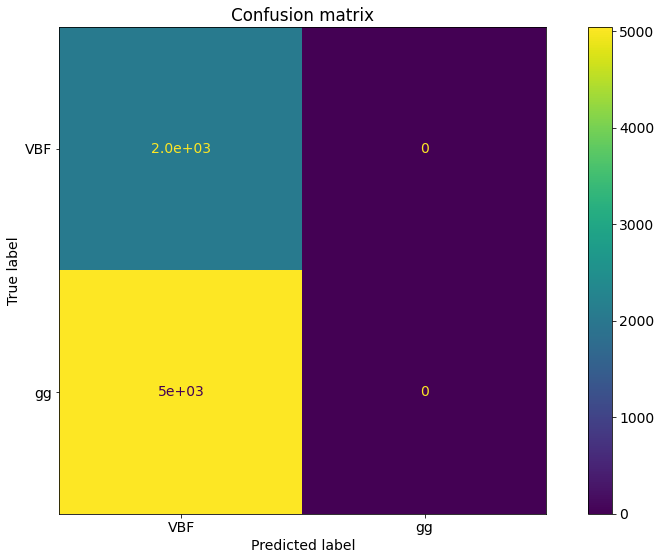

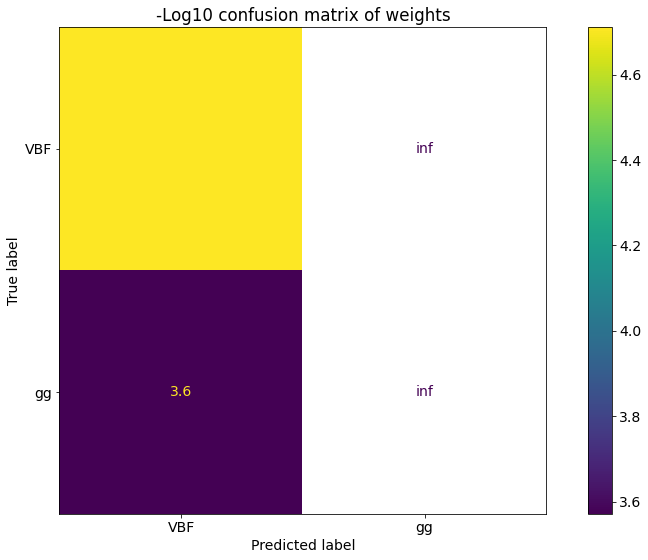

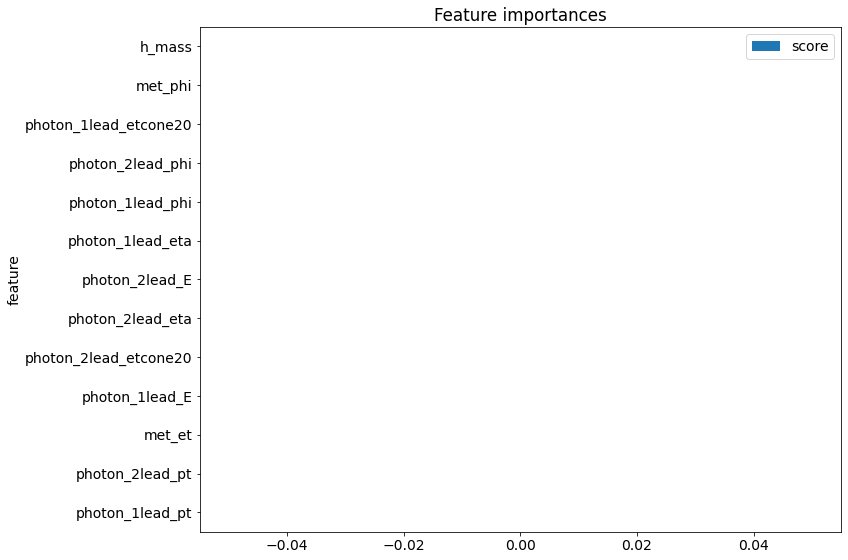

In [143]:
save_figures(
    "xgboost",
    report(xgboost_cv.best_estimator_, significant_feature_pipeline, significant_feature_pipeline.transform(d_test), drop=["weight"])
)

## Conclusion

Within this toy project we managed to reproduce Higgs mass peak, while discovering that ATLAS Open Data is not enough to reproduce backgrounds taking part in the process. Moreover, we managed to set up the end-to-end pipeline for feature processing and learning. It is implemented in Python but, thanks to NumPy and "family", still not less efficient than C++ codes.

Feature processing pipeline, now provides basic set of simple features and can easily be extended to producing more sophisticated collections without loss in speed. We learned that jagged data is the essential feature of in HEP analyses, and future attempts to train on particle data should account on this. Having this in mind, we, however, decided to follow the simplest approach for the sake of building a wider picture of the data analysis pipeline in ATLAS.

Finally, several models have been tested in order to classify Higgs boson production mechanisms. All of them show results highly biased towards gluon-gluon fusion. This most probably caused by the fact that the data is imbalanced by both parameters: number of events and event weights. Sometimes minority by number of events can consist majority in weights.